In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil
import tensorflow as tf
import re
import math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import gc
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold
from keras_cv_attention_models import efficientnet

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Configs

In [2]:
class CFG:

    model_name = 'EfficientNetV2B0'

    batch_size = 32
    
    epochs = 4

    folds = 4

    seed = 123

    img_size = [256, 256]

    augment   = True

    transform_prob = 0.90
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 4.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 30.0
    wshift = 30.0

    hflip = True
    vflip = True

    p_pixel_aug = 0.90
    cont = [0.5, 2]
    bri  = 0.5

    clip = False

    drop_prob   = 0.6
    drop_cnt    = 10
    drop_size   = 0.05

    mixup_prob = 0.5
    mixup_alpha = 0.2
    
    cutmix_prob = 0.5
    cutmix_alpha = 2.5

    target_col  = [ "bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

### Seeding

In [3]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')

seeding(CFG.seed)

seeding done!!!


### Prepare Dataframe

In [4]:
df = pd.read_csv('./Dataset/train.csv')

test_df = pd.read_csv('./Dataset/test.csv')
test_df['image_path'] = (f'./Dataset/test_images/'
                          + test_df.patient_id.astype(str)+ '/' 
                          + test_df.series_id.astype(str) + '/' 
                          + test_df.instance_number.astype(str) 
                          + '.png')

### Asign Fold numbers

In [5]:
df['stratify'] = ''

for col in CFG.target_col:
    df['stratify'] += df[col].astype(str)

df = df.reset_index(drop=True)

sgkf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for  fold , (train_idx, val_idx) in enumerate(sgkf.split(df, df['stratify'], df['patient_id'])):
    df.loc[val_idx, 'fold'] = fold

display(df.groupby(['fold', 'patient_id']).size())

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


fold  patient_id
0.0   4353           43
      5649           10
      6962            4
      7026           26
      7482           77
                   ... 
3.0   56981          68
      58324           9
      60993          29
      63113         362
      65456          16
Length: 246, dtype: int64

### Data Augmentation

In [6]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)



def random_float(shape=[], minval=0.0, maxval=1.0):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)



# make affine transformation matrix
# https://cs.kwansei.ac.jp/prog1/affine.html
def get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift):

    # degrees to radians
    shear = math.pi * shear / 180.


    def get_3x3_mat(list):
        return tf.reshape(tf.concat([list], axis=0), [3, 3])
    

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')

    # for shear matrix
    cos = tf.math.cos(shear)
    sin = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  sin,  zero,
                                zero, cos,  zero,
                                zero, zero, one])
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    #　return composite transformation
    return K.dot(shear_matrix, K.dot(zoom_matrix, shift_matrix))



# apply affine transformation
def transform(image, DIM=CFG.img_size):

    # add padding to align image sizes
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]

    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rotation     = CFG.rot * tf.random.normal([1], dtype='float32')
    shear        = CFG.shr * tf.random.normal([1], dtype='float32')
    height_zoom  = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    width_zoom   = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    height_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    width_shift  = CFG.wshift * tf.random.normal([1], dtype='float32')

    # inverse of get_matrix
    # https://daeudaeu.com/reverse-matorix/
    transformation_matrix     =tf.linalg.inv(get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift))
    transformation_matrix_flat=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)

    # apply affine transformation to image
    image=tfa.image.transform(image, transformation_matrix_flat, fill_mode=CFG.fill_mode)

    # rotate image
    image=tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)

    # remove padding
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]

    # align image sizes
    image = tf.reshape(image, [*DIM, 3])  

    return image



# apply dropout to image
def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, cutout = 5, size = 0.1):

    # boolean to int
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)

    if (P==0) or (cutout==0) or (size==0):
        return image
    
    for c in range(cutout):

        # choose random coordinates
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)

        # determine cutout square
        width = tf.cast(size*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-width//2)
        yb = tf.math.minimum(DIM[0],y+width//2)
        xa = tf.math.maximum(0,x-width//2)
        xb = tf.math.minimum(DIM[1],x+width//2)

        # image after cutout
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) # cutouted square
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

    return image



# apply mixup amd cutmix to image
# https://cvml-expertguide.net/terms/dl/regularization/data-augmentation/
# mixup
def get_mixup(alpha, prob):
    
    
    # https://qiita.com/AseiSugiyama/items/66a75610c569a23ac493
    @tf.function
    def mixup(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        images = lamb * images + (1.0 - lamb) * tf.roll(images, shift=1, axis=0)
        labels = lamb * labels + (1.0 - lamb) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels
    
    return mixup



# cutmix
def get_cutmix(alpha, prob):


    @tf.function
    def cutmix(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        width = tf.cast(image_shape[2], tf.int32)
        height = tf.cast(image_shape[1], tf.int32)

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        r_x = random_int([], minval=0, maxval=width)
        r_y = random_int([], minval=0, maxval=height)
        r = 0.5 * tf.math.sqrt(1.0 - lamb)
        r_w_half = tf.cast(r * tf.cast(width, tf.float32), tf.int32)
        r_h_half = tf.cast(r * tf.cast(height, tf.float32), tf.int32)

        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, width), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, width), tf.int32)
        y1 = tf.cast(tf.clip_by_value(r_y - r_h_half, 0, height), tf.int32)
        y2 = tf.cast(tf.clip_by_value(r_y + r_h_half, 0, height), tf.int32)

        # outer-pad patch -> [0, 0, 1, 1, 0, 0]
        patch1 = images[:, y1:y2, x1:x2, :]  # [batch, height, width, channel]
        patch1 = tf.pad(patch1, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])  # outer-pad

        # inner-pad patch -> [1, 1, 0, 0, 1, 1]
        patch2 = tf.roll(images, shift=1, axis=0)[:, y1:y2, x1:x2, :]
        patch2 = tf.pad(patch2, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])
        patch2 = tf.roll(images, shift=1, axis=0) - patch2  # inner-pad = img - outer-pad

        images = patch1 + patch2  # cutmix img

        lambda2 = tf.cast((1.0 - (x2 - x1) * (y2 - y1) / (width * height)), tf.float32)
        labels = lambda2 * labels + (1.0 - lambda2) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels

    return cutmix

### Data pipeline
1. Reads the PNG file and then decode it to tf.tensor
2. Resizes the image
3. Changes the datatype to float32
4. Cache the data for boosting up the speed
5. Apply augmentations 
6. Split the data into baches

In [7]:
def build_decoder(with_labels=True, target_size=CFG.img_size):


    def decode_image(path):

        file_binary = tf.io.read_file(path)
        image = tf.image.decode_png(file_binary, channels=3, dtype=tf.uint8)
        image = tf.image.resize(image, CFG.img_size, method='bilinear')
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*CFG.img_size, 3])

        return image
    

    def decode_label(label):
        
        label = tf.cast(label, tf.float32)
        
        return (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    def decode_with_labels(path, label):

        return decode_image(path), decode_label(label)

    return decode_with_labels if with_labels else decode_image
    


def build_augmenter(with_labels=True, dim=CFG.img_size):

    def augment(image, DIM=dim):

        if random_float() < CFG.transform_prob:
            image = transform(image, DIM=DIM)

        image = tf.image.random_flip_left_right(image) if CFG.hflip else image
        image = tf.image.random_flip_up_down(image) if CFG.vflip else image

        if random_float() < CFG.p_pixel_aug:
            image = tf.image.random_contrast(image, CFG.cont[0], CFG.cont[1])
            image = tf.image.random_brightness(image, CFG.bri)
        
        image = tf.clip_by_value(image, 0, 1)  if CFG.clip else image     
        image = tf.reshape(image, [*DIM, 3])

        return image

    def augment_with_labels(image, label):

        return augment(image), label
    
    return augment_with_labels if with_labels else augment



# https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3
def build_dataset(paths, labels=None, batch_size=CFG.batch_size, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=False, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    # https://tensorflow.classcat.com/2019/03/23/tf20-alpha-guide-data-performance/
    AUTO = tf.data.experimental.AUTOTUNE

    slices = paths if labels is None else (paths, labels)

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds

    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds

    if augment and labels is not None:
        ds = ds.map(lambda image, label: (dropout(image,
                                                  DIM=CFG.img_size, 
                                                  PROBABILITY=CFG.drop_prob, 
                                                  cutout=CFG.drop_cnt,
                                                  size=CFG.drop_size), label),num_parallel_calls=AUTO)

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)

    
    #if augment and labels is not None:
    #    if CFG.cutmix_prob:
    #        ds = ds.map(get_cutmix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
    #    if CFG.mixup_prob:
    #        ds = ds.map(get_mixup(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    

    ds = ds.prefetch(AUTO)

    return ds

### Build Model

In [8]:
def build_model(model_name=CFG.model_name, dim=CFG.img_size):


        # backbone
        base = getattr(efficientnet, model_name)(input_shape=(*dim,3), pretrained='imagenet', num_classes=0)

        inp = base.inputs

        x = base.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # necks
        x_bowel = tf.keras.layers.Dense(32, activation='silu')(x)
        x_extra = tf.keras.layers.Dense(32, activation='silu')(x)
        x_liver = tf.keras.layers.Dense(32, activation='silu')(x)
        x_kidney = tf.keras.layers.Dense(32, activation='silu')(x)
        x_spleen = tf.keras.layers.Dense(32, activation='silu')(x)

        # heads
        out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
        out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
        out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
        out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
        out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

        out = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

        model = tf.keras.Model(inputs=inp, outputs=out)

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

        loss = {'bowel':tf.keras.losses.BinaryCrossentropy(),
                'extra':tf.keras.losses.BinaryCrossentropy(),
                'liver':tf.keras.losses.CategoricalCrossentropy(),
                'kidney':tf.keras.losses.CategoricalCrossentropy(),
                'spleen':tf.keras.losses.CategoricalCrossentropy()}

        metrics = {'bowel':'accuracy',
                   'extra':'accuracy',
                   'liver':'accuracy',
                   'kidney':'accuracy',
                   'spleen':'accuracy'}

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model


### Learning rate scheduler

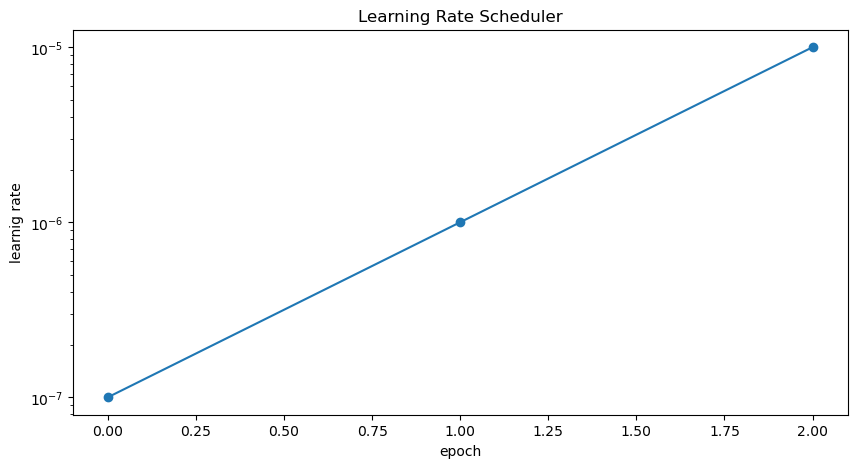

In [9]:
# the optimal lr is 10^-5 ish
def get_lr_callback(batch_size=8, plot=False):

    lr_min     = 0.000001
   
    def lrfn(epoch):

        lr = lr_min * (10 ** epoch)

        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(CFG.batch_size, plot=True )

### Train model

In [10]:

for fold in np.arange(CFG.folds):

    train_df = df.query("fold!=@fold")
    valid_df = df.query("fold==@fold")

    train_paths  = train_df.image_path.values
    train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths  = valid_df.image_path.values
    valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    test_paths   = test_df.image_path.values

    K.clear_session()

    model = build_model(CFG.model_name, dim=CFG.img_size)

    train_ds = build_dataset(train_paths, train_labels)
    valid_ds = build_dataset(valid_paths, valid_labels)

    callbacks = []
    ## save best model after each fold
    save = tf.keras.callbacks.ModelCheckpoint('fold-%i.h5'%fold, monitor='val_loss', 
                                              verbose=1, save_best_only=True,
                                              save_weights_only=False, mode='min', save_freq='epoch')
    callbacks +=[save]
    callbacks += [get_lr_callback(CFG.batch_size)]


    history = model.fit(train_ds, validation_data = valid_ds, 
                        epochs=CFG.epochs, steps_per_epoch=None, 
                        callbacks = callbacks, verbose=1)
                        
    best_epoch = np.argmin(history.history['val_loss'])
    best_loss = history.history['val_loss'][best_epoch]
    best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
    best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
    best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
    best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
    best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

    best_acc = np.mean([best_acc_bowel, best_acc_extra, best_acc_liver, best_acc_kidney, best_acc_spleen])
    print(f'FOLD {fold} RESULTS')
    print(f'BEST Loss  : {best_loss:.3f}\nBEST Acc   : {best_acc:.3f}\nBEST Epoch : {best_epoch}')
    print(f'Bowel : {best_acc_bowel:.3f}')
    print(f'Extravasation : {best_acc_extra:.3f}')
    print(f'Liver: {best_acc_liver:.3f}')
    print(f'Kidney: {best_acc_kidney:.3f}')
    print(f'Spleen: {best_acc_spleen:.3f}\n')


>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
Epoch 1/3
299/299 [==============================] - ETA: 0s - loss: 4.5894 - bowel_loss: 0.7065 - extra_loss: 0.6654 - liver_loss: 1.0180 - kidney_loss: 1.1318 - spleen_loss: 1.0677 - bowel_accuracy: 0.4925 - extra_accuracy: 0.6279 - liver_accuracy: 0.5236 - kidney_accuracy: 0.2828 - spleen_accuracy: 0.4383
Epoch 1: val_loss improved from inf to 4.57731, saving model to fold-0.h5


/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


299/299 [==============================] - 326s 906ms/step - loss: 4.5894 - bowel_loss: 0.7065 - extra_loss: 0.6654 - liver_loss: 1.0180 - kidney_loss: 1.1318 - spleen_loss: 1.0677 - bowel_accuracy: 0.4925 - extra_accuracy: 0.6279 - liver_accuracy: 0.5236 - kidney_accuracy: 0.2828 - spleen_accuracy: 0.4383 - val_loss: 4.5773 - val_bowel_loss: 0.7123 - val_extra_loss: 0.6848 - val_liver_loss: 1.0408 - val_kidney_loss: 1.1042 - val_spleen_loss: 1.0352 - val_bowel_accuracy: 0.4870 - val_extra_accuracy: 0.5620 - val_liver_accuracy: 0.4936 - val_kidney_accuracy: 0.3365 - val_spleen_accuracy: 0.5157 - lr: 1.0000e-07
Epoch 2/3
299/299 [==============================] - ETA: 0s - loss: 4.4660 - bowel_loss: 0.7022 - extra_loss: 0.6549 - liver_loss: 0.9667 - kidney_loss: 1.0919 - spleen_loss: 1.0504 - bowel_accuracy: 0.5036 - extra_accuracy: 0.6646 - liver_accuracy: 0.6403 - kidney_accuracy: 0.3510 - spleen_accuracy: 0.4748
Epoch 2: val_loss improved from 4.57731 to 4.39965, saving model to fold

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


336/336 [==============================] - 363s 888ms/step - loss: 4.7154 - bowel_loss: 0.6932 - extra_loss: 0.6866 - liver_loss: 1.1135 - kidney_loss: 1.1395 - spleen_loss: 1.0825 - bowel_accuracy: 0.5208 - extra_accuracy: 0.5458 - liver_accuracy: 0.3570 - kidney_accuracy: 0.2981 - spleen_accuracy: 0.4152 - val_loss: 4.7951 - val_bowel_loss: 0.6988 - val_extra_loss: 0.6981 - val_liver_loss: 1.1181 - val_kidney_loss: 1.1748 - val_spleen_loss: 1.1053 - val_bowel_accuracy: 0.5096 - val_extra_accuracy: 0.5017 - val_liver_accuracy: 0.3304 - val_kidney_accuracy: 0.2350 - val_spleen_accuracy: 0.3575 - lr: 1.0000e-07
Epoch 2/3
336/336 [==============================] - ETA: 0s - loss: 4.5592 - bowel_loss: 0.6898 - extra_loss: 0.6730 - liver_loss: 1.0541 - kidney_loss: 1.0873 - spleen_loss: 1.0550 - bowel_accuracy: 0.5286 - extra_accuracy: 0.5985 - liver_accuracy: 0.4941 - kidney_accuracy: 0.3989 - spleen_accuracy: 0.4773
Epoch 2: val_loss improved from 4.79507 to 4.53124, saving model to fold

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 398s 1s/step - loss: 4.7363 - bowel_loss: 0.6861 - extra_loss: 0.6781 - liver_loss: 1.1698 - kidney_loss: 1.0585 - spleen_loss: 1.1437 - bowel_accuracy: 0.5421 - extra_accuracy: 0.5721 - liver_accuracy: 0.2412 - kidney_accuracy: 0.4112 - spleen_accuracy: 0.2666 - val_loss: 4.7558 - val_bowel_loss: 0.7057 - val_extra_loss: 0.6664 - val_liver_loss: 1.1814 - val_kidney_loss: 1.0579 - val_spleen_loss: 1.1444 - val_bowel_accuracy: 0.4662 - val_extra_accuracy: 0.6144 - val_liver_accuracy: 0.2047 - val_kidney_accuracy: 0.4101 - val_spleen_accuracy: 0.2506 - lr: 1.0000e-07
Epoch 2/3
318/318 [==============================] - ETA: 0s - loss: 4.5769 - bowel_loss: 0.6850 - extra_loss: 0.6661 - liver_loss: 1.0973 - kidney_loss: 1.0130 - spleen_loss: 1.1156 - bowel_accuracy: 0.5498 - extra_accuracy: 0.6053 - liver_accuracy: 0.3757 - kidney_accuracy: 0.5069 - spleen_accuracy: 0.3171
Epoch 2: val_loss improved from 4.75584 to 4.49217, saving model to fold-2.

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


269/269 [==============================] - 379s 1s/step - loss: 4.6534 - bowel_loss: 0.7006 - extra_loss: 0.7241 - liver_loss: 1.0110 - kidney_loss: 1.0969 - spleen_loss: 1.1208 - bowel_accuracy: 0.4911 - extra_accuracy: 0.4235 - liver_accuracy: 0.5194 - kidney_accuracy: 0.3742 - spleen_accuracy: 0.3007 - val_loss: 4.6109 - val_bowel_loss: 0.6989 - val_extra_loss: 0.7200 - val_liver_loss: 0.9785 - val_kidney_loss: 1.1111 - val_spleen_loss: 1.1024 - val_bowel_accuracy: 0.5018 - val_extra_accuracy: 0.4482 - val_liver_accuracy: 0.5876 - val_kidney_accuracy: 0.3397 - val_spleen_accuracy: 0.3450 - lr: 1.0000e-07
Epoch 2/3
269/269 [==============================] - ETA: 0s - loss: 4.5335 - bowel_loss: 0.7002 - extra_loss: 0.7152 - liver_loss: 0.9664 - kidney_loss: 1.0569 - spleen_loss: 1.0949 - bowel_accuracy: 0.4947 - extra_accuracy: 0.4459 - liver_accuracy: 0.6117 - kidney_accuracy: 0.4654 - spleen_accuracy: 0.3480
Epoch 2: val_loss improved from 4.61094 to 4.39528, saving model to fold-3.

### Process prediction values

In [11]:
def mc_proc(pred):
    argmax = np.argmax(pred, axis=1).astype('uint8')
    one_hot = tf.keras.utils.to_categorical(argmax, num_classes=3)
    return one_hot.astype('uint8')

def sc_proc(pred, thr=0.5):
    proc_pred = (pred > thr).astype('uint8')
    return proc_pred

def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype='float32')

    proc_pred[:, 0] = 1 - pred[:, 0] # bowel-healthy
    proc_pred[:, 1] = pred[:, 0] # bowel-injured
    proc_pred[:, 2] = 1 - pred[:, 1] # extra-healthy
    proc_pred[:, 3] = pred[:, 1] # extra-injured
    
    proc_pred[:, 4:7] = pred[:, 2:5] # liver
    proc_pred[:, 7:10] = pred[:, 5:8] # kidney
    proc_pred[:, 10:13] = pred[:, 8:11] # spleen

    return proc_pred

### Model configs

In [13]:
CKPT_DIRS = [
    ([512, 512], './'),
]

MODEL_CONFIGS = []
for img_size, ckpt_dir in  CKPT_DIRS:
    paths = sorted(glob(os.path.join(ckpt_dir, '*h5')))[0:CFG.folds]
    if len(paths)==0:
        print('no model found for :',base_dir)
    MODEL_CONFIGS.append([img_size, paths])
display(MODEL_CONFIGS)

[[[512, 512], ['./fold-0.h5', './fold-1.h5', './fold-2.h5', './fold-3.h5']]]

### Infer

In [26]:
patient_ids = test_df['patient_id'].unique()

patient_ids.sort()

patient_preds = np.zeros(shape=(len(patient_ids), 2*2 + 3*3), dtype='float32')

preds = np.zeros(shape=(1, 11), dtype=np.float32)

for pidx, patient_id in tqdm(enumerate(patient_ids)):

    patient_df = test_df[test_df['patient_id'] != patient_id]

    model_preds = np.zeros(shape=(1, 11), dtype=np.float32)

    print(f'Patient ID: {patient_id}')

    for midx, (img_size, fold_paths) in enumerate(MODEL_CONFIGS):

        patient_paths = patient_df.image_path.tolist()

        min_batchsize = len(patient_paths)
        CFG.batch_size = min(min_batchsize, CFG.batch_size)

        dtest = build_dataset(patient_paths, batch_size=CFG.batch_size, repeat=False, 
                             shuffle=False, augment=False, cache=False,
                             decode_fn=build_decoder(with_labels=False, target_size=CFG.img_size),)
        
        for fold_path in fold_paths:
            
            model = tf.keras.models.load_model(fold_path, compile=False)
             
            pred = model.predict(dtest, verbose=1)
            pred = np.concatenate(pred, axis=-1).astype('float32')
            pred = pred[:len(patient_paths), :]
            pred = np.mean(pred.reshape(1, len(patient_paths), 11), axis=0)
            pred = np.max(pred, axis=0) # taking max prediction of all ct scans for a patient

            model_preds += pred / (len(fold_paths)*len(MODEL_CONFIGS))
                                   
            del model, pred; gc.collect()
        
        del dtest, patient_paths; gc.collect()

        patient_preds[pidx, :] += post_proc(model_preds)[0]

    del model_preds; gc.collect()


0it [00:00, ?it/s]

Patient ID: 48843
1/1 [==============================] - 15s 15s/step


1it [01:05, 65.58s/it]

Patient ID: 50046
1/1 [==============================] - 15s 15s/step


2it [02:11, 65.91s/it]

Patient ID: 63706
1/1 [==============================] - 16s 16s/step


3it [03:21, 67.06s/it]


In [27]:
patient_preds

array([[0.40062475, 0.59937525, 0.22364593, 0.7763541 , 0.9151776 ,
        0.15811184, 0.13074802, 0.82899284, 0.23013932, 0.15492648,
        0.665516  , 0.21227756, 0.29290068],
       [0.37804663, 0.62195337, 0.27994287, 0.72005713, 0.812729  ,
        0.15811184, 0.13626885, 0.64639366, 0.2462556 , 0.16300628,
        0.5986967 , 0.23405993, 0.29851973],
       [0.3460881 , 0.6539119 , 0.21036804, 0.78963196, 0.9151776 ,
        0.07496762, 0.11230343, 0.82899284, 0.23245439, 0.13489307,
        0.665516  , 0.20801646, 0.2221129 ]], dtype=float32)

In [ ]:
test_df

,image_path,patient_id,series_id,instance_number
0,./Dataset/test_images/50046/24574/30.png,50046,24574,30
1,./Dataset/test_images/63706/39279/30.png,63706,39279,30
2,./Dataset/test_images/48843/62825/30.png,48843,62825,30


### Create submission

In [28]:
pred_df = pd.DataFrame({'patient_id':patient_ids,})

sub_df = pd.read_csv('./sample_submission.csv')
pred_df = pred_df.merge(sub_df, on='patient_id', how='right')

for i, row in enumerate(patient_preds):
    pred_df.loc[i, 'bowel_healthy'] = row[0]
    pred_df.loc[i, 'bowel_injury'] = row[1]
    pred_df.loc[i, 'extravasation_healthy'] = row[2]
    pred_df.loc[i, 'extravasation_injury'] = row[3]
    pred_df.loc[i, 'kidney_healthy'] = row[4]
    pred_df.loc[i, 'kidney_low'] = row[5]
    pred_df.loc[i, 'kidney_high'] = row[6]
    pred_df.loc[i, 'liver_healthy'] = row[7]
    pred_df.loc[i, 'liver_low'] = row[8]
    pred_df.loc[i, 'liver_high'] = row[9]
    pred_df.loc[i, 'spleen_healthy'] = row[10]
    pred_df.loc[i, 'spleen_low'] = row[11]
    pred_df.loc[i, 'spleen_high'] = row[12]

pred_df.to_csv('submission01.csv', index=False)
